<h1><center>Primal Dual Hybrid Gradient Algorithm </center></h1>

In this demo, we learn how to use the **Primal Dual Hybrid Algorithm (PDHG)** introduced by [Champolle & Pock](https://hal.archives-ouvertes.fr/hal-00490826/document) for Tomography Reconstruction. We will solve the following minimisation problem under different regularisation terms, i.e., $\|\cdot\|_{1}$, Tikhonov regularisation with $L=\nabla$ and Total variation:

<a id='all_reg'></a>
$$\begin{equation}
u^{*} =\underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + 
\begin{cases}
\alpha\,\|u\|_{1}, & \\[10pt]
\alpha\,\|\nabla u\|_{2}^{2}, & \\[10pt]
\alpha\,\mathrm{TV}(u) + \mathbb{I}_{\{u\geq 0\}}(u).
\end{cases}
\tag{1}
\end{equation}$$

where,

1. $g$ is the Acqusisition data obtained from the detector.

1. $\mathcal{A}$ is the projection operator ( _Radon transform_ ) that maps from an image-space to an acquisition space, i.e., $\mathcal{A} : \mathbb{X} \rightarrow \mathbb{Y}, $ where $\mathbb{X}$ is an __ImageGeometry__ and $\mathbb{Y}$ is an __AcquisitionGeometry__.

1. $\alpha$: regularising parameter that measures the trade-off between the fidelity and the regulariser terms.

1. The total variation (isotropic) is defined as $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$

1. $\mathbb{I}_{\{u>0\}}(u) : = 
\begin{cases}
0, & \mbox{ if } u>0\\
\infty , & \mbox{ otherwise}
\,
\end{cases}
$, $\quad$ a non-negativity constraint for the minimiser $u$.

<h2><center><u> Learning objectives </u></center></h2>   

- Load the data using a CIL reader: `TXRMDataReader`
- Preprocess the data using CIL processor:  `Binner`, `TransmissionAbsorptionConverter`
- Run FBP and SIRT reconstructions
- Setup PDHG for 3 different regularisers: `$L^{1}$, Tikhonov a

<!---
1. Brief intro for non-smooth minimisation problems using PDHG algorithm.
1. Setup and run PDHG with (__non-smooth__) $L^{1}$ norm regulariser. __(No BlockFramework)__
1. Use __BlockFunction__ and __Block Framework__ to setup PDHG for Tikhonov and TV reconstructions.
1. Run Total variation reconstruction with different regularising parameters and compared with FBP and SIRT reconstructions.
    

At the end of this demo, we will be able to reproduce all the reconstructions presented in the figure below. One can observe that the __Tikhonov regularisation__ with $L = \nabla$ was able to remove the noise but could not preserve the edges. However, this can be achieved with the the total variation reconstruction.

<img src="CIL-Demos/Notebooks/images/recon_all_tomo.jpeg"  width="1500"/>
--->

<!-- <h2><center><u> Prerequisites </u></center></h2>

- AcquisitionData, AcquisitionGeometry, AstraProjectorSimple.
- BlockOperator, Gradient.
- FBP, SIRT, CGLS, Tikhonov. -->

We first import all the necessary libraries for this notebook.

<!---
In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$\min_{u} \mathcal{F}(K u) + \mathcal{G}(u)$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals
    
    - $\mathcal{F}: Y \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: X \rightarrow \mathbb{R}$
    
    
2. $K$ is a continuous linear operator acting from a space X to another space Y :

$$K : X \rightarrow Y \quad $$ 

with operator norm  defined as $$\| K \| = \max\{ \|K x\|_{Y} : \|x\|_{X}\leq 1 \}.$$  

**Note**: The Gradient operator  has  $\|\nabla\| = \sqrt{8} $ and for the projection operator we use the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the greatest eigenvalue of $K$.

--->

In [1]:
# Import libraries

from cil.framework import BlockDataContainer

from cil.optimisation.functions import L2NormSquared, L1Norm, BlockFunction, MixedL21Norm, IndicatorBox, TotalVariation
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG, SIRT

from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D
from cil.utilities.jupyter import islicer

from cil.io import TXRMDataReader

from cil.processors import Binner, TransmissionAbsorptionConverter

import matplotlib.pyplot as plt

import numpy as np

import os

# Details on the walnut data

# Load walnut data

In [2]:
reader = TXRMDataReader()
filename = os.path.abspath('/mnt/data/CCPi/Dataset/CCPi/valnut_tomo-A.txrm')

reader.set_up(file_name=filename, angle_unit='radian')
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder(['vertical','angle','horizontal'])

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ag3D.config.angles.angle_data = -ag3D.config.angles.angle_data
ig3D = ag3D.get_ImageGeometry()

astropy module not found


facility None
image_width 1024
image_height 1024
data_type 5
number_of_images 1601
pixel_size 46.07780456542969
reference_filename b'D:\\cagu\\undervisning\\Per Christian\\valnut\\Scout_10W_40kV_exp5s_bin2_LFOV__filter_2014-03-20_1558_08.xrm\x00\xcf\xd7\xc8\xed\xfe\x07\x00\x00p\x03,Z\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\x84\xf5Y\\\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x01\x00\x00\x00\x00\x80@\x00\x00\x00\x00\x00xeVersion\x00\xed\xfe\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0f\x00\x00\x00\x00\x00\x00\x00\x13\x00\x00\x00\x00\x00\x00\x00\xfe\xff\xff\xff\xff\xff\xff\xff10.5.2073.11095\x00\x0f\x00\x00\x00'
reference_data_type 10
thetas [-3.14156655 -3.13770178 -3.13376269 ...  3.13373819  3.13764452
  3.14159958]
x_positions [-1069.20007324  -686.25       -1226.5        ... -1004.40002441
 -1162.05004883  -789.5       ]


In [3]:
print(" Acquisition Geometry 3D: {} with labels {}".format(ag3D.shape, ag3D.dimension_labels))
print(" Image Geometry 3D: {} with labels {}".format(ig3D.shape, ig3D.dimension_labels))

 Acquisition Geometry 3D: (1024, 1601, 1024) with labels ('vertical', 'angle', 'horizontal')
 Image Geometry 3D: (1024, 1024, 1024) with labels ('vertical', 'horizontal_y', 'horizontal_x')


# Show full 3D sinogram.

/home/vaggelis/miniconda3/envs/cil21_tigre_astra/lib/python3.8/site-packages/cil/utilities/display.py:298: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


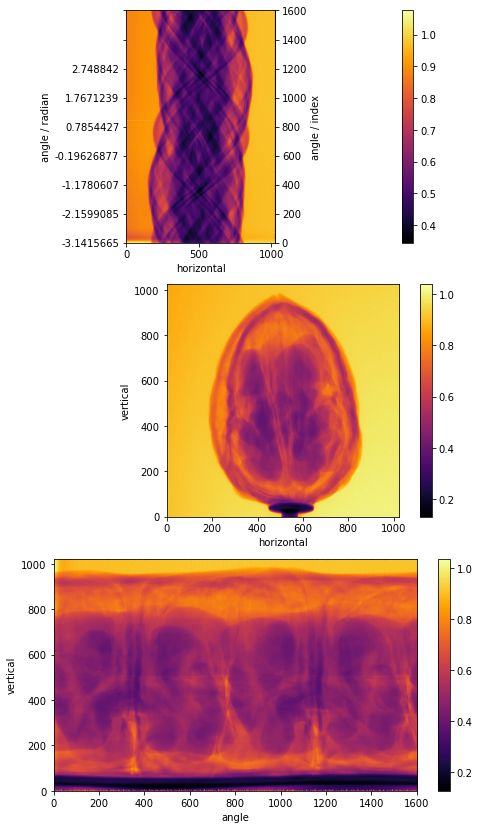

In [4]:
show2D([data3D.subset(vertical=512),
       data3D.subset(angle=800),
       data3D.subset(horizontal=512,force=True)], cmap="inferno", num_cols=1, size=(15,15))

# Slice through projections

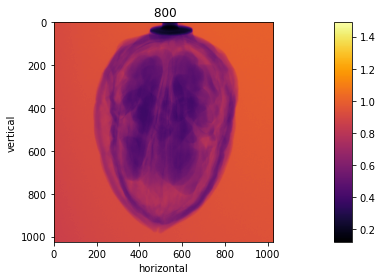

IntSlider(value=800, continuous_update=False, description='angle', max=1600)

In [5]:
islicer(data3D, direction=1, cmap="inferno")

# For demonstration purposes, we extract the centered slice and select only 80 angles from the total 1601 angles.

1. We use the `Binner` processor with step size of 10.
1. We use the `TransmissionAbsorptionConverter` to convert from transmission measurements to absorption based on the Beer-Lambert law.

**Note:** To avoid circular artifacts in the reconstruction space, we subtract the mean value of a background ROI, i.e., ROI that does not contain the walnut.

In [25]:
data2D = data3D.subset(vertical='centre')
binned_data2D = Binner(roi={'angle':(0,1601,10),'horizontal':(120,-120,2)})(data2D)
absorption_data = TransmissionAbsorptionConverter()(binned_data2D) 

# Remove circular artifacts
absorption_data -= np.mean(absorption_data.as_array()[80:100,0:30])

In [26]:
# Get Image and Acquisition geometries for one slice
ag2D = absorption_data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

In [27]:
print(" Acquisition Geometry 2D: {} with labels {}".format(ag2D.shape, ag2D.dimension_labels))
print(" Image Geometry 2D: {} with labels {}".format(ig2D.shape, ig2D.dimension_labels))

 Acquisition Geometry 2D: (160, 392) with labels ('angle', 'horizontal')
 Image Geometry 2D: (392, 392) with labels ('horizontal_y', 'horizontal_x')


# Define Projection Operator (from Astra-Toolbox)

**Note:** An alternative option is to use the TIGRE projection opearator:

<div class="alert alert-block" 
     style="background-color: green; 
            width: 600px;margin: auto">
    

```python

    from cil.plugins.tigre import ProjectionOperator as TigreOp
    
    A = TigreOp(ig, ag)
            
```

</div>
<br></br>

In [28]:
A = ProjectionOperator(ig2D, ag2D, device = 'gpu')

## FBP and SIRT reconstuctions

Now, let's perform simple reconstructions using the **Filtered Back Projection (FBP)** and **Simultaneous Iterative Reconstruction Technique [SIRT](appendix.ipynb/#SIRT) .**

Recall, for FBP we type

<div class="alert alert-block" 
     style="background-color: green; 
            width: 570px;margin: auto">
    

```python

    fbp_recon = FBP(ig, ag, device = 'gpu')(absorption_data)
            
```

</div>
<br></br>


For SIRT, we type

<div class="alert alert-block" 
     style="background-color: green; 
            width: 600px;margin: auto">
    

```python
    
    x_init = ig.allocate()
    sirt = SIRT(initial = x_init, operator = A, data=absorption_data, 
            max_iteration = 50, update_objective_interval=10)
    sirt.run(verbose=1)
    sirt_recon = sirt.solution 
       
```

</div>
<br></br>



**Note**: In SIRT, a non-negative constraint can be used with

<div class="alert alert-block" 
     style="background-color: green; 
            width: 400px;margin: auto">
    

```python    
    
    constraint=IndicatorBox(lower=0)        
    
```

</div>
<br></br>

   

## Exercise 1: Run FBP and SIRT reconstructions

Use the code blocks described above and run FBP (`fbp_recon`) and SIRT (`sirt_recon`) reconstructions.

**Note**: To display the results, use 

<div class="alert alert-block" 
     style="background-color: green; 
            width: 800px;margin: auto">
    

```python    
    
    show2D([fbp_recon,sirt_recon], title = ['FBP reconstruction','SIRT reconstruction'], 
            cmap = 'inferno')    
    
```

</div>
<br></br>



SIRT setting up
SIRT configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        300         0.000          1.35442e+04
      100        300         0.037          4.61838e+01
      200        300         0.038          4.31080e+01
      300        300         0.046          4.26368e+01
-------------------------------------------------------
      300        300         0.046          4.26368e+01
Stop criterion has been reached.



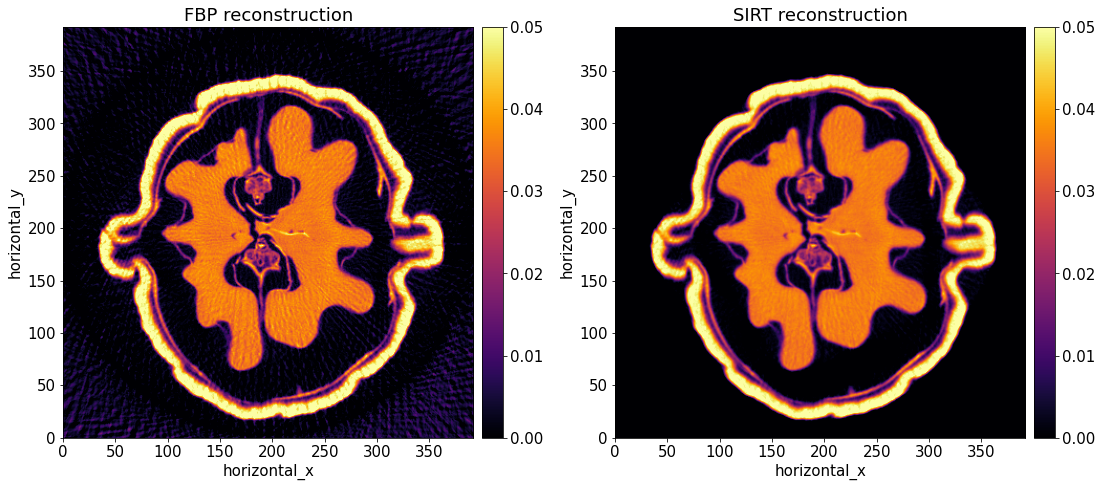

In [29]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig2D, ag2D,  device = 'gpu')(absorption_data)

# Setup and run the SIRT algorithm, with  non-negative constraint
x_init = ig2D.allocate()  
sirt = SIRT(initial = x_init, operator = A, data=absorption_data, constraint = IndicatorBox(lower=0),
           max_iteration = 300, update_objective_interval=100)
sirt.run(verbose=1)
sirt_recon = sirt.solution

# Show reconstructions
show2D([fbp_recon,sirt_recon], 
       title = ['FBP reconstruction','SIRT reconstruction'], 
       cmap = 'inferno', fix_range=(0,0.05))

<h2><center> Why PDHG? </center></h2>

In the previous demo, we presented the __Tikhonov regularisation__ for tomography reconstruction, i.e.,

<a id='Tikhonov'></a>
$$\begin{equation}
u^{*} =\underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \alpha\|L u\|^{2}_{2}
\tag{Tikhonov}
\end{equation}$$

where we can use either the `GradientOperator` ($L = \nabla) $ or the `IdentityOperator` ($L = \mathbb{I}$). Due to the $\|\cdot\|^{2}_{2}$ terms, one can observe that the above objective function is differentiable. However, this is not always the case. Consider for example an $L^{1}$ norm for the fidelity, i.e., $\|\mathcal{A} u - g\|_{1}$ or an $L^{1}$ norm of the regulariser i.e., $\|u\|_{1}$.

Using the __PDHG algorithm__, we can solve minimisation problems where the objective is not differentiable, and the only required assumption is convexity. 

<h2><center> $L^{1}$ regularisation </center></h2>

Let $L=\mathbb{I}$ in [Tikhonov regularisation](#Tikhonov) and replace the

$$\alpha^{2}\|L u\|^{2}_{2}\quad\mbox{  with  }\quad \alpha\|u\|_{1}, $$ 

which results to a non-differentiable objective function. Hence, we have 

<a id='Lasso'></a>
$$\begin{equation}
u^{*} =\underset{u}{\operatorname{argmin}} \frac{1}{2} \| \mathcal{A} u - g\|^{2} + \alpha\|u\|_{1} 
\tag{$L^{2}-L^{1}$}
\end{equation}$$


<h2><center> How to setup and run PDHG? </center></h2>

In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$\begin{equation}
\min_{u\in\mathbb{X}} \mathcal{F}(K u) + \mathcal{G}(u)
\label{PDHG_form}
\tag{2}
\end{equation}$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals:
    
    - $\mathcal{F}: \mathbb{Y} \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: \mathbb{X} \rightarrow \mathbb{R}$
    
    
1. $K$ is a continuous linear operator acting from a space $\mathbb{X}$ to another space $\mathbb{Y}$ :

    $$K : \mathbb{X} \rightarrow \mathbb{Y} \quad $$ 

    with operator norm  defined as $$\| K \| = \max\{ \|K x\|_{\mathbb{Y}} : \|x\|_{\mathbb{X}}\leq 1 \}.$$  


We can write the problem [($L^{2}-L^{1})$](#Lasso) into [(2)](#PDHG_form), if we let

1. $K = \mathcal{A} \quad \Longleftrightarrow \quad $ `K = A`  

1. $\mathcal{F}: Y \rightarrow \mathbb{R}, \mbox{ with } \mathcal{F}(z) := \frac{1}{2}\| z - g \|^{2}, \quad \Longleftrightarrow \quad$ ` F = 0.5 * L2NormSquared(absorption_data)`

1. $\mathcal{G}: X \rightarrow \mathbb{R}, \mbox{ with } \mathcal{G}(z) := \alpha\|z\|_{1}, \quad \Longleftrightarrow \quad$ ` G = alpha * L1Norm()`.

Hence, we can verify that with the above setting we have that [($L^{2}-L^{1})$](#Lasso)$\Rightarrow$[(2)](#PDHG_form) for $x=u$,  $$\underset{u}{\operatorname{argmin}} \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \alpha\|u\|_{1} = 
\underset{u}{\operatorname{argmin}} \mathcal{F}(\mathcal{A}u) + \mathcal{G}(u) = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) $$

The algorithm is described in the [Appendix](appendix.ipynb/#PDHG) and for every iteration, we solve two (proximal-type) subproblems, i.e., __primal & dual problems__ where 
$\mbox{prox}_{\tau \mathcal{G}}(x)$ and $\mbox{prox}_{\sigma \mathcal{F^{*}}}(x)$ are the **proximal operators** of $\mathcal{G}$ and $\mathcal{F}^{*}$ (convex conjugate of $\mathcal{F}$).

$$\begin{equation}
\mbox{prox}_{\lambda f}(x) = \underset{z}{\operatorname{argmin}} \frac{1}{2}\|z - x \|^{2} + \lambda 
f(z) \end{equation}
$$


To setup and run of PDHG in CIL:

<div class="alert alert-block alert-info" 
     style="background-color: green; 
            width: 600px;margin: auto">
    

```python
    
    pdhg = PDHG(f = F, g = G, operator = K, tau = tau, sigma = sigma, 
            max_iterations = 500, update_objective_interval = 100)
    pdhg.run(verbose=1)
       
```

</div>
<br></br>



---
**Note:** The variable $\sigma, \tau$ are called the primal/dual stepsizes and need to satisfy $\sigma\tau\|K\|^{2}<1$ for PDHG convergence. The speed of the algorithm depends heavily on the choice
of these stepsizes.

---

**Note:** The operator norm of $K$ is computed with
```python
normK = K.norm()
```
using the [Power Method](https://en.wikipedia.org/wiki/Power_iteration) to approximate the greatest eigenvalue of $K$.

---

**Note:** To monitor convergence, we use `pdhg.run(verbose=1)` that prints the objective value of the primal problem, or `pdhg.run(verbose=2)` that prints the objective value of the primal and dual problems, as well as the primal dual gap. Nothing is printed with `verbose=0`.


<a id='sigma_tau'></a>
### Define operator $K$, functions $\mathcal{F}$  and $\mathcal{G}$

In [78]:
K = A
F = 0.5 * L2NormSquared(b=absorption_data)
alpha = 0.01
G = alpha * L1Norm()

### Compute operator norm and step-sizes $\sigma, \tau$, such that $\sigma\tau\|K\|^{2}<1$

In [79]:
normK = K.norm()
sigma = 1.
tau = 1/(sigma*normK**2)

### Setup and run PDHG

In [80]:
# Setup and run PDHG
pdhg_l1 = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_l1.run(verbose=1)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.77211e+03
      100        500         0.090          3.69080e+01
      200        500         0.085          3.52904e+01
      300        500         0.073          3.50487e+01
      400        500         0.071          3.49680e+01
      500        500         0.069          3.49300e+01
-------------------------------------------------------
      500        500         0.069          3.49300e+01
Stop criterion has been reached.



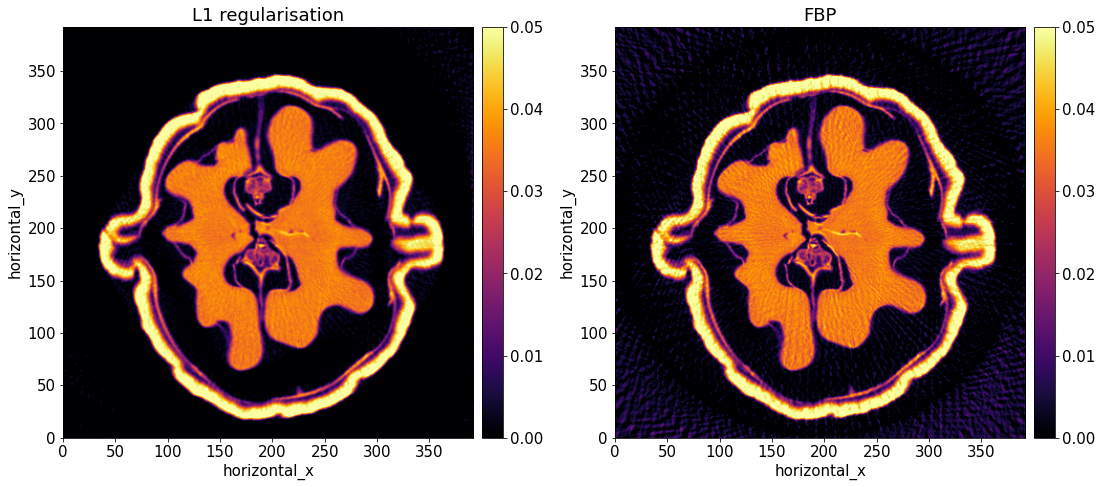

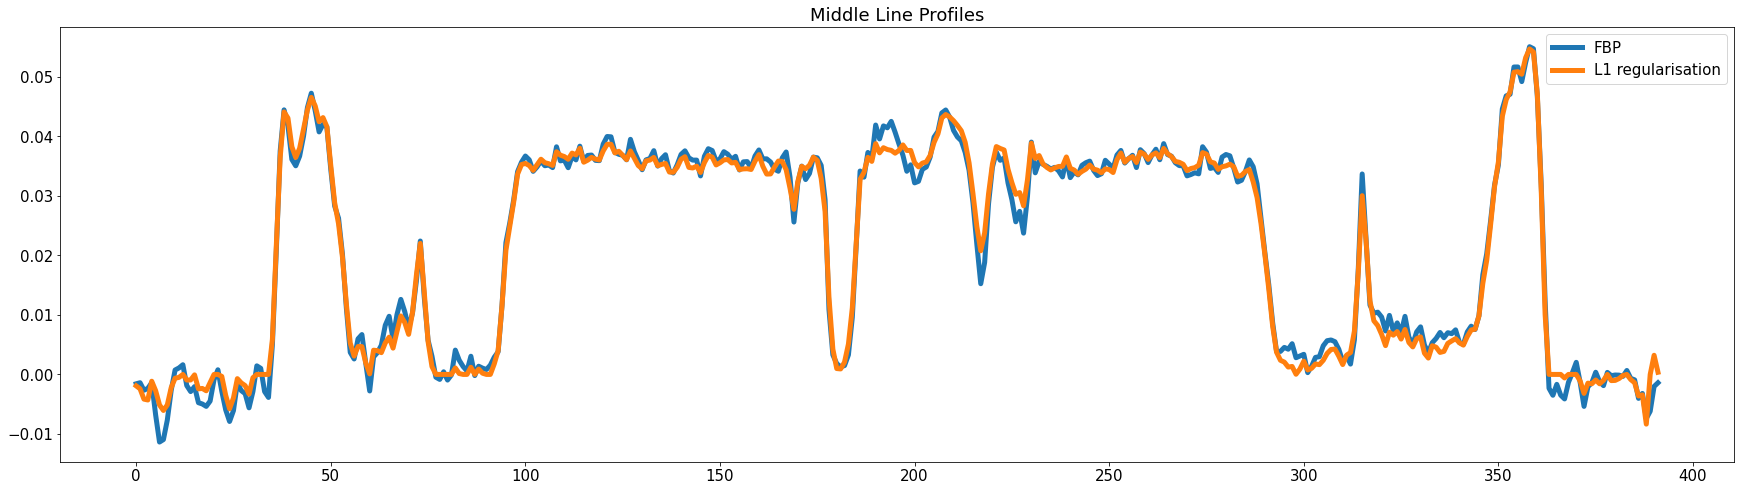

In [81]:
# Show reconstuction and ground truth
show2D([pdhg_l1.solution,fbp_recon], fix_range=(0,0.05), title = ['L1 regularisation', 'FBP'], cmap = 'inferno')

# Plot middle line profile
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'lines.linewidth': 5})
plt.plot(fbp_recon.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'FBP')
plt.plot(pdhg_l1.solution.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'L1 regularisation')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

<h2><center> PDHG for Total Variation Regularisation </center></h2>

Now, we continue with the setup of the PDHG algorithm using the Total variation regulariser appeared in the [(1)](#all_reg) minimisation problem.

Similarly, to the [($L^{2}-L^{1}$)](#Lasso) problem, we need to express [($L^{2}-TV$)](#all_reg) in the general form of [PDHG](#PDHG_form). This can be done using two different formulations:

1. Explicit formulation: All the subproblems in the PDHG algorithm have a closed form solution.
1. Implicit formulation: One of the subproblems in the PDHG algorithm is not solved explicitly but an inner solver is used.

---
<h2><center> Explicit PDHG </center></h2>

For the setup of the **Explicit PDHG**, we let

$$\begin{align}
& f_{1}: \mathbb{Y} \rightarrow \mathbb{R}, \quad f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1}, \mbox{ ( the TV term ) }\\
& f_{2}: \mathbb{X} \rightarrow \mathbb{R}, \quad f_{2}(z_{2}) = \frac{1}{2}\|z_{2} - g\|_{2}^{2}, \mbox{ ( the data-fitting term ). }
\end{align}$$

<div class="alert alert-block alert-info" 
     style="background-color: green; 
            width: 400px;margin: auto">
    

```python
    
    f1 = alpha * MixedL21Norm()
    f2 = 0.5 * L2NormSquared(b=absorption_data)
       
```

</div>
<br></br>


For $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we define a separable function, e.g., [BlockFunction,](appendix.ipynb/#BlockFunction)

$$\mathcal{F}(z) : = \mathcal{F}(z_{1},z_{2}) = f_{1}(z_{1}) + f_{2}(z_{2})$$


<div class="alert alert-block alert-info" 
     style="background-color: green; 
            width: 300px;margin: auto">
    

```python
    
    F = BlockFunction(f1, f2).
       
```

</div>
<br></br>

In order to obtain an element $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we need to define a `BlockOperator` $K$, using the two operators involved in [$L^{2}-TV$](#TomoTV), i.e., the `GradientOperator` $\nabla$ and the `ProjectionOperator` $\mathcal{A}$.

$$ \mathcal{K} = 
\begin{bmatrix}
\nabla\\
\mathcal{A}
\end{bmatrix}
$$

<div class="alert alert-block alert-info" 
     style="background-color: green; 
            width: 300px;margin: auto">
    

```python
    
    Grad = GradientOperator(ig)
    K = BlockOperator(Grad, A)
       
```

</div>
<br></br>

Finally, we enforce a non-negativity constraint by letting $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u)$

<div class="alert alert-block alert-info" 
     style="background-color: green; 
            width: 300px;margin: auto">
    

```python
    
    G = IndicatorBox(lower=0)
       
```

</div>
<br></br>


Again, we can verify that with the above setting we can express our problem into [(2)](#PDHG_form), for $x=u$

$$
\begin{align}
\underset{u}{\operatorname{argmin}}\alpha\|\nabla u\|_{2,1} + \frac{1}{2}\|\mathcal{A} u - g\|^{2}_{2} + \mathbb{I}_{\{u>0\}}(u) =  \underset{u}{\operatorname{argmin}} f_{1}(\nabla u) + f_{2}(\mathcal{A}u) + \mathbb{I}_{\{u>0\}}(u) \\ = \underset{u}{\operatorname{argmin}} F(
\begin{bmatrix}
\nabla \\
\mathcal{A}
\end{bmatrix}u) + \mathbb{I}_{\{u>0\}}(u) = 
\underset{u}{\operatorname{argmin}} \mathcal{F}(Ku) + \mathcal{G}(u) = \underset{x}{\operatorname{argmin}} \mathcal{F}(Kx) + \mathcal{G}(x) 
\end{align}
$$


In [82]:
# Define BlockFunction F
alpha_tv = 0.0001
f1 = alpha_tv * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption_data)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = GradientOperator(ig2D)
K = BlockOperator(Grad, A)

# Define Function G
G = IndicatorBox(lower=0)

normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg_tv_explicit = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_tv_explicit.run(verbose=1)

Initialised GradientOperator with C backend running with  16  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.77211e+03


/home/vaggelis/miniconda3/envs/cil21_tigre_astra/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.114          2.23256e+01
      200        500         0.111          2.14687e+01
      300        500         0.108          2.14477e+01
      400        500         0.095          2.14470e+01
      500        500         0.098          2.14469e+01
-------------------------------------------------------
      500        500         0.098          2.14469e+01
Stop criterion has been reached.



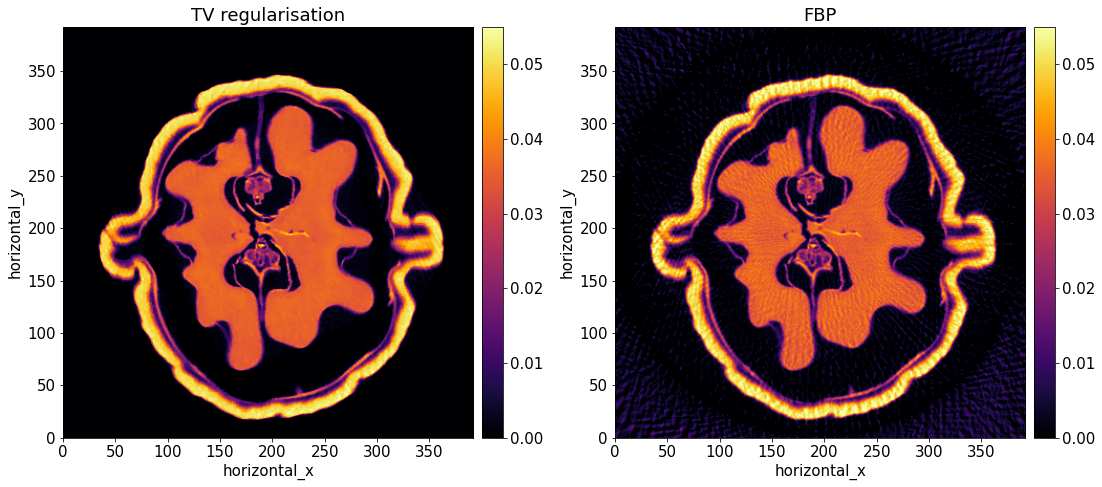

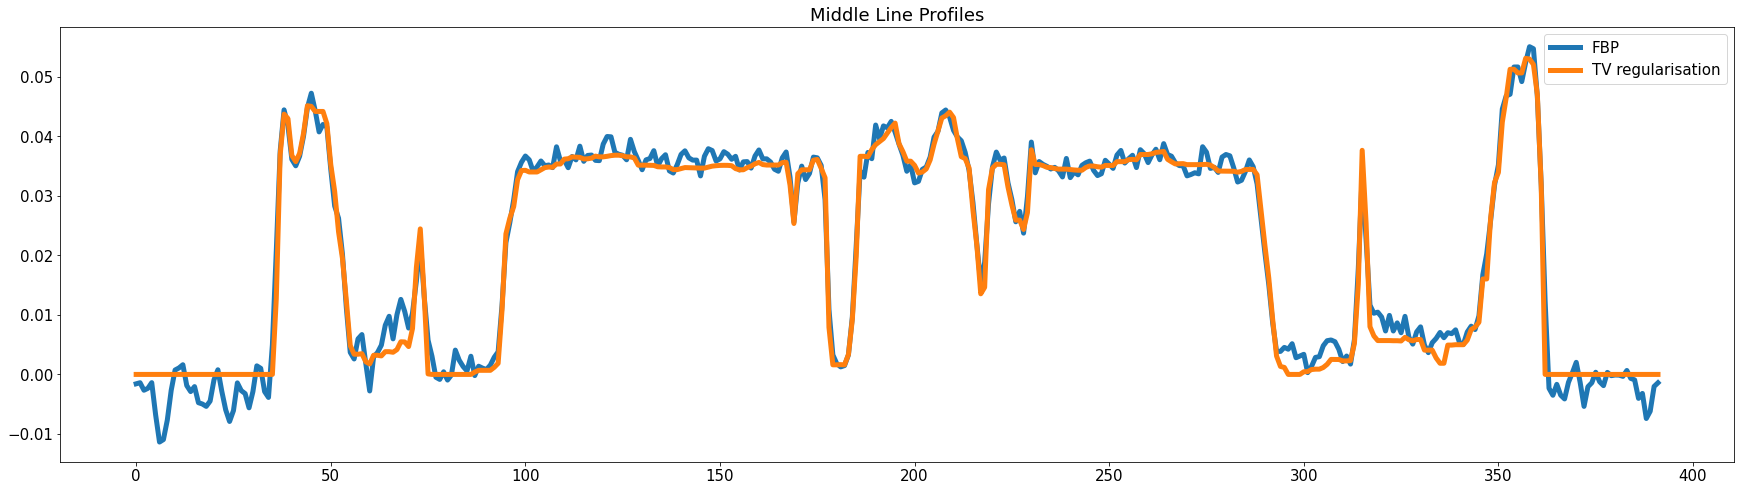

In [83]:
# Show reconstuction and ground truth
show2D([pdhg_tv_explicit.solution,fbp_recon], fix_range=(0,0.055), title = ['TV regularisation','FBP'], cmap = 'inferno')

# Plot middle line profile
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'lines.linewidth': 5})
plt.plot(fbp_recon.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'FBP')
plt.plot(pdhg_tv_explicit.solution .subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'TV regularisation')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

## Exercise 2: Setup and run PDHG algorithm for Tikhonov regularisation

Use exactly the same code as above and replace:

$$f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1} \mbox{ with } f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2}^{2}.$$


In [84]:
# Define BlockFunction F
alpha_tikhonov = 0.05
f1 = alpha_tikhonov * L2NormSquared()
F = BlockFunction(f1, f2)

# Setup and run PDHG
pdhg_tikhonov_explicit = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_tikhonov_explicit.run(verbose=1)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.77211e+03
      100        500         0.103          2.87530e+01
      200        500         0.097          2.85319e+01
      300        500         0.104          2.85302e+01
      400        500         0.093          2.85302e+01
      500        500         0.110          2.85302e+01
-------------------------------------------------------
      500        500         0.110          2.85302e+01
Stop criterion has been reached.



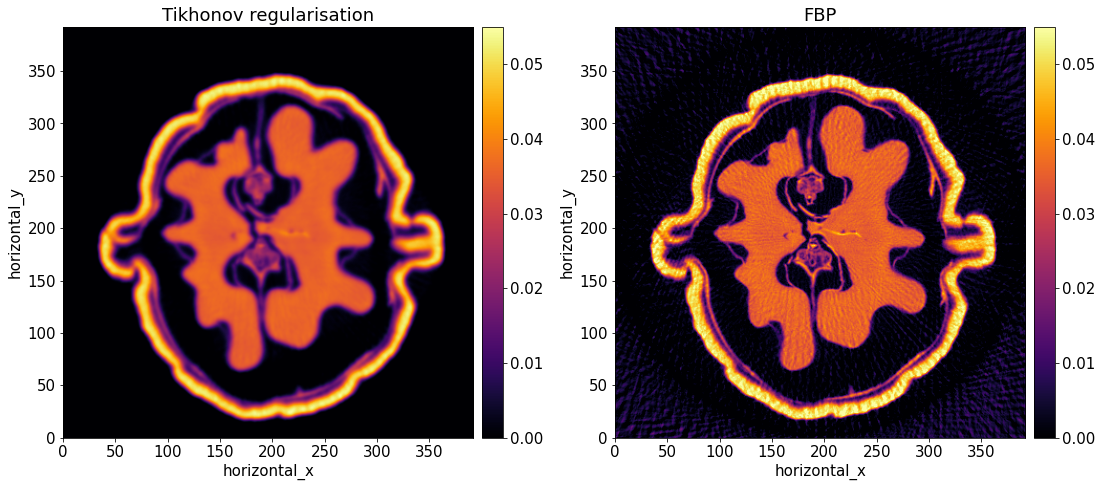

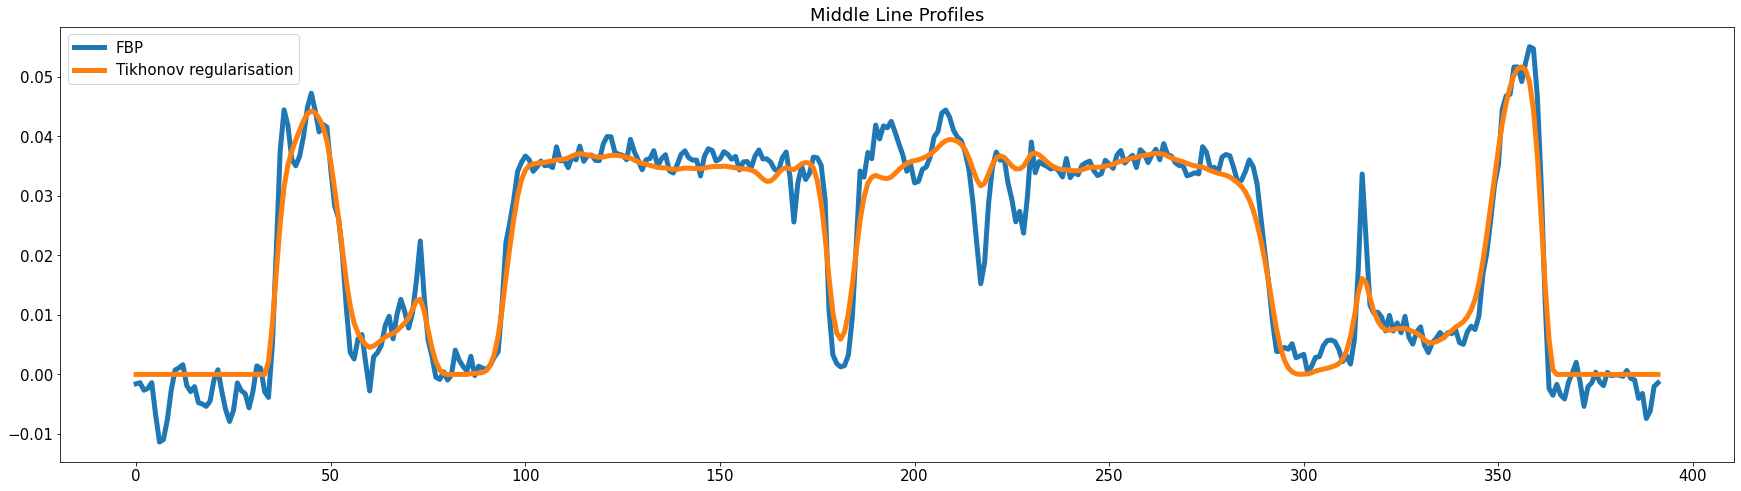

In [85]:
# Show reconstuction and ground truth
show2D([pdhg_tikhonov_explicit.solution,fbp_recon], fix_range=(0,0.055), title = ['Tikhonov regularisation','FBP'], cmap = 'inferno')

# Plot middle line profile
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'lines.linewidth': 5})
plt.plot(fbp_recon.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'FBP')
plt.plot(pdhg_tikhonov_explicit.solution .subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'Tikhonov regularisation')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

---
<h2><center> Implicit PDHG </center></h2>

In the implicit PDHG, one of the proximal subproblems, i.e., $\mathrm{prox}_{\tau\mathcal{F}^{*}}$ or $\mathrm{prox}_{\sigma\mathcal{G}}$ are not solved exactly and an iterative solver is used. For the setup of the **Implicit PDHG**, we let

$$\begin{align}
& \mathcal{F}: \mathbb{Y} \rightarrow \mathbb{R}, \quad \mathcal{F}(z_{1}) = \frac{1}{2}\|z_{1} - g\|_{2}^{2}\\
& \mathcal{G}: \mathbb{X} \rightarrow \mathbb{R}, \quad \mathcal{G}(z_{2}) = \alpha\, \mathrm{TV}(z_{2}) = \|\nabla z_{2}\|_{2,1}
\end{align}$$

For the function $\mathcal{G}$, we can use the `TotalVariation` `Function` class from CIL or the `FGP_TV` `Function` class from the `CCPi-Regularisation Toolkit`. For these functions, the `proximal` method implements an iterative solver, namely the **Fast Gradient Projection (FGP)** algorithm that solves the **dual** problem of

$$\begin{equation}
\mathrm{prox}_{\tau G}(u) = \underset{z}{\operatorname{argmin}} \frac{1}{2} \| u - z\|^{2} + \tau\,\alpha\,\mathrm{TV}(z) +  \mathbb{I}_{\{z>0\}}(z),
\end{equation}
$$
for every PDHG iteration. Hence, we need to specify the number of iterations for the FGP algorithm. In addition, we can enforce a non-negativity constraint using `lower=0.0`. For the `FGP_TV` class, we can use `device=gpu` or `device=cpu` to speed up this inner solver.


<div class="alert alert-block alert-info" 
     style="background-color: green; 
            width: 700px;margin: auto">
    

```python

    G = alpha * FGP_TV(max_iteration=100, nonnegativity = True, device = 'gpu')
    
    G = alpha * TotalVariation(max_iteration=100, lower=0.)
                
```

</div>
<br></br>

## Exercise 3: Setup and run implicit PDHG algorithm with the Total variation regulariser

- Using the FGP_TV class from the CCPi regularisation plugin.

    **Note:** In the FGP_TV implementation no pixel size information is included when in the forward and backward of the finite difference operator. Hence, we need to divide our regularisation parameter by the pixel size, e.g., $$\frac{\alpha}{\mathrm{ig2D.voxel\_size\_y}}$$
    
- Using the TotalVariation class, from CIL. This solves the TV denoising problem (using the FGP algorithm) in CPU. Therefore it is signifantly slower but can be very useful when there is not enough GPU memory.


## Implicit PDHG: using FGP_TV

In [87]:
F = 0.5 * L2NormSquared(b=absorption_data)
G = (alpha_tv/ig2D.voxel_size_y) * FGP_TV(max_iteration=100, device='gpu')
K = A

normK = K.norm()
sigma = 1./normK
tau = 1./normK

# Setup and run PDHG
pdhg_tv_implicit_regtk = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_tv_implicit_regtk.run(verbose=1)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        500         0.000          6.77211e+03
      100        500         0.091          2.14873e+01
      200        500         0.087          2.14471e+01
      300        500         0.088          2.14469e+01
      400        500         0.095          2.14469e+01
      500        500         0.097          2.14469e+01
-------------------------------------------------------
      500        500         0.097          2.14469e+01
Stop criterion has been reached.



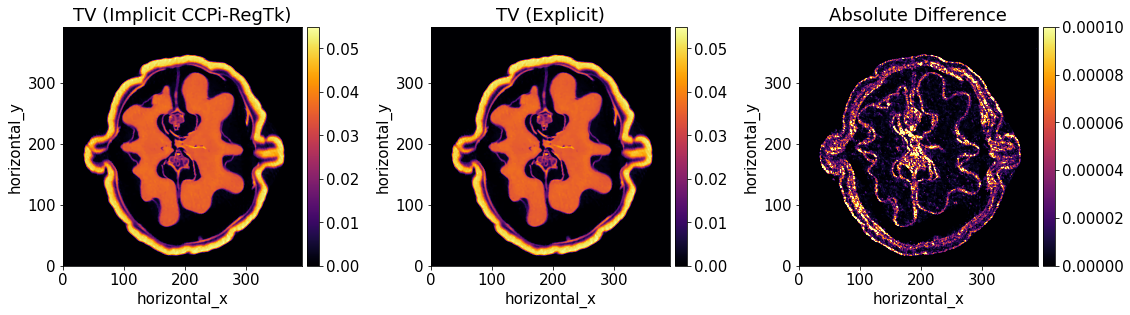

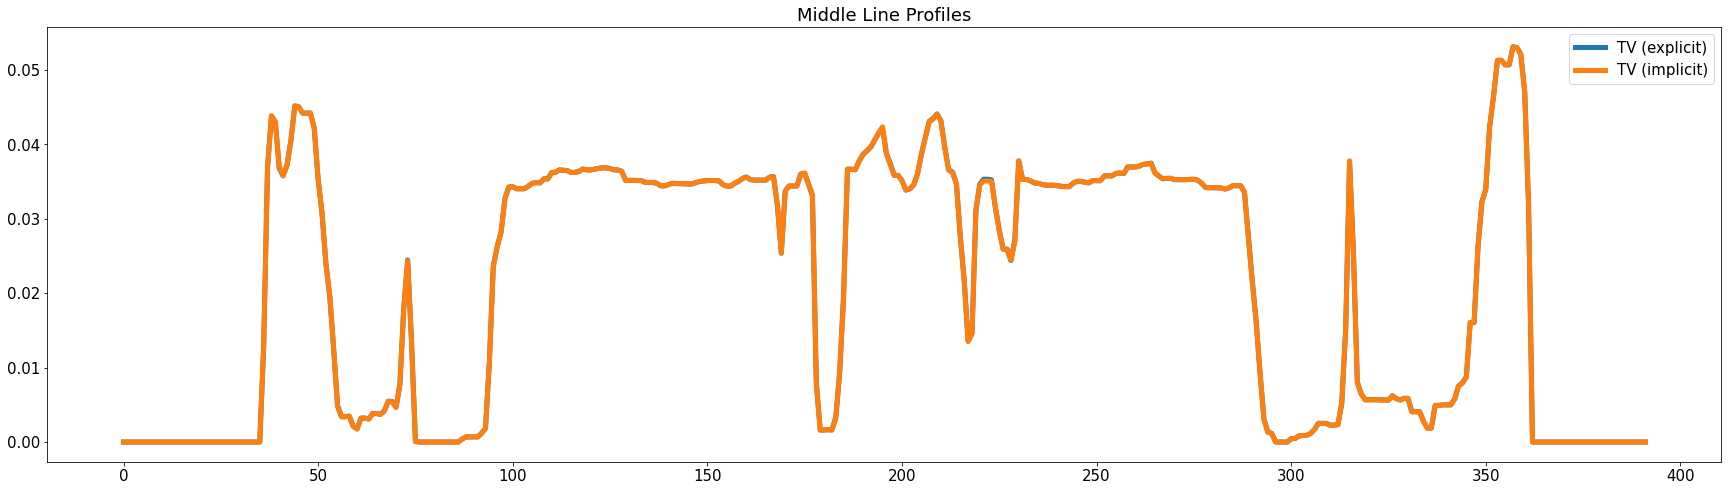

In [101]:
# Show reconstuction and ground truth
show2D([pdhg_tv_implicit_regtk.solution,pdhg_tv_explicit.solution, 
        (pdhg_tv_explicit.solution-pdhg_tv_implicit_regtk.solution).abs()], 
       fix_range=[(0,0.055),(0,0.055),(0,1e-4)],
       title = ['TV (Implicit CCPi-RegTk)','TV (Explicit)', 'Absolute Difference'], 
       cmap = 'inferno', num_cols=3)

# Plot middle line profile
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'lines.linewidth': 5})
plt.plot(pdhg_tv_explicit.solution.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'TV (explicit)')
plt.plot(pdhg_tv_implicit_regtk.solution.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'TV (implicit)')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

## Implicit PDHG: using TotalVariation 

**Note:** This takes about 8-10 minutes for 500 iterations. We use only 200 iterations for this reconstruction.

In [104]:
G = alpha_tv * TotalVariation(max_iteration=100, lower=0.)

# Setup and run PDHG
pdhg_tv_implicit_cil = PDHG(f = F, g = G, operator = K, sigma = sigma, tau = tau, 
            max_iteration = 500,
            update_objective_interval = 100)
pdhg_tv_implicit_cil.run(200, verbose=1)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
Initialised GradientOperator with C backend running with  16  threads
        0        500         0.000    6.77211e+03  -0.00000e+00    6.77211e+03
      100        500         1.306    2.14873e+01   2.14719e+01    1.54927e-02
      200        500         1.290    2.14471e+01   2.15908e+01   -1.43725e-01
----------------------------------------------------------------------------
      200        500         1.290    2.14471e+01   2.15908e+01   -1.43725e-01
Stop criterion has been reached.



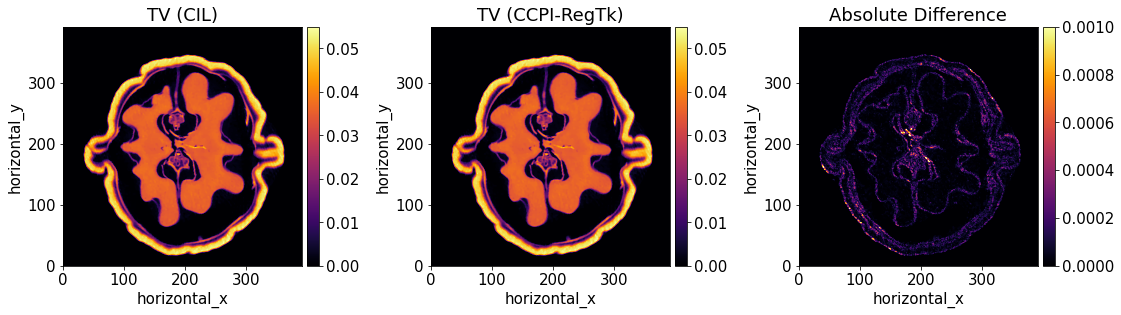

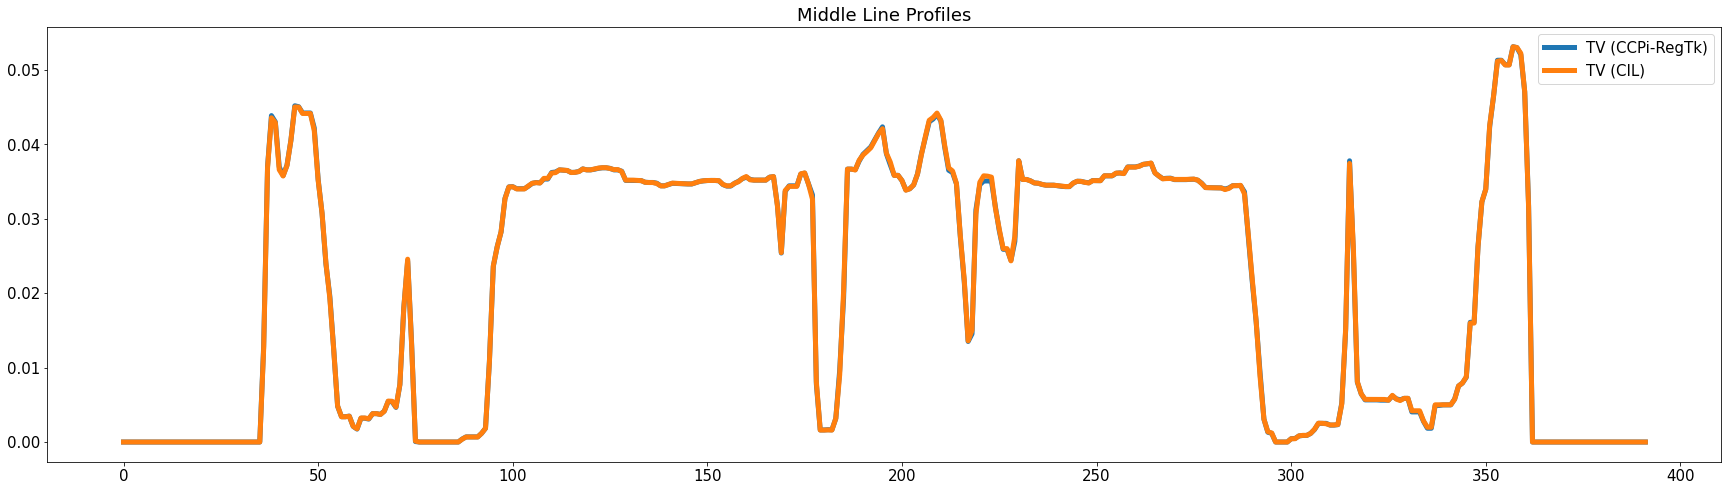

In [105]:
# Show reconstuction and ground truth
show2D([pdhg_tv_implicit_regtk.solution,
        pdhg_tv_implicit_cil.solution,
        (pdhg_tv_implicit_cil.solution-pdhg_tv_implicit_regtk.solution).abs()], 
       fix_range=[(0,0.055),(0,0.055),(0,1e-3)], num_cols=3,
       title = ['TV (CIL)','TV (CCPI-RegTk)', 'Absolute Difference'], 
       cmap = 'inferno')

# Plot middle line profile
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'lines.linewidth': 5})
plt.plot(pdhg_tv_implicit_regtk.solution.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'TV (CCPi-RegTk)')
plt.plot(pdhg_tv_implicit_cil.solution.subset(horizontal_y = int(ig2D.voxel_num_y/2)).as_array(), label = 'TV (CIL)')
plt.legend()
plt.title('Middle Line Profiles')
plt.show()

# FBP reconstruction with all the projection angles.

In [106]:
binned_data3D = Binner(roi={'horizontal':(120,-120,2)})(data3D)
absorption_data3D = TransmissionAbsorptionConverter()(binned_data3D.subset(vertical=512))
absorption_data3D -= np.mean(absorption_data3D.as_array()[80:100,0:30])
ag3D = absorption_data3D.geometry
ag3D.set_angles(ag3D.angles, initial_angle=0.2, angle_unit='radian')
ig3D = ag3D.get_ImageGeometry()

fbp_recon3D = FBP(ig3D, ag3D)(absorption_data3D)

# Show all reconstructions 

- FBP (1601 projections)
- FBP (160 projections)
- SIRT (160 projections)
- $L^{1}$ regularisation (160 projections)
- Tikhonov regularisation (160 projections)
- Total variation regularisation (160 projections)

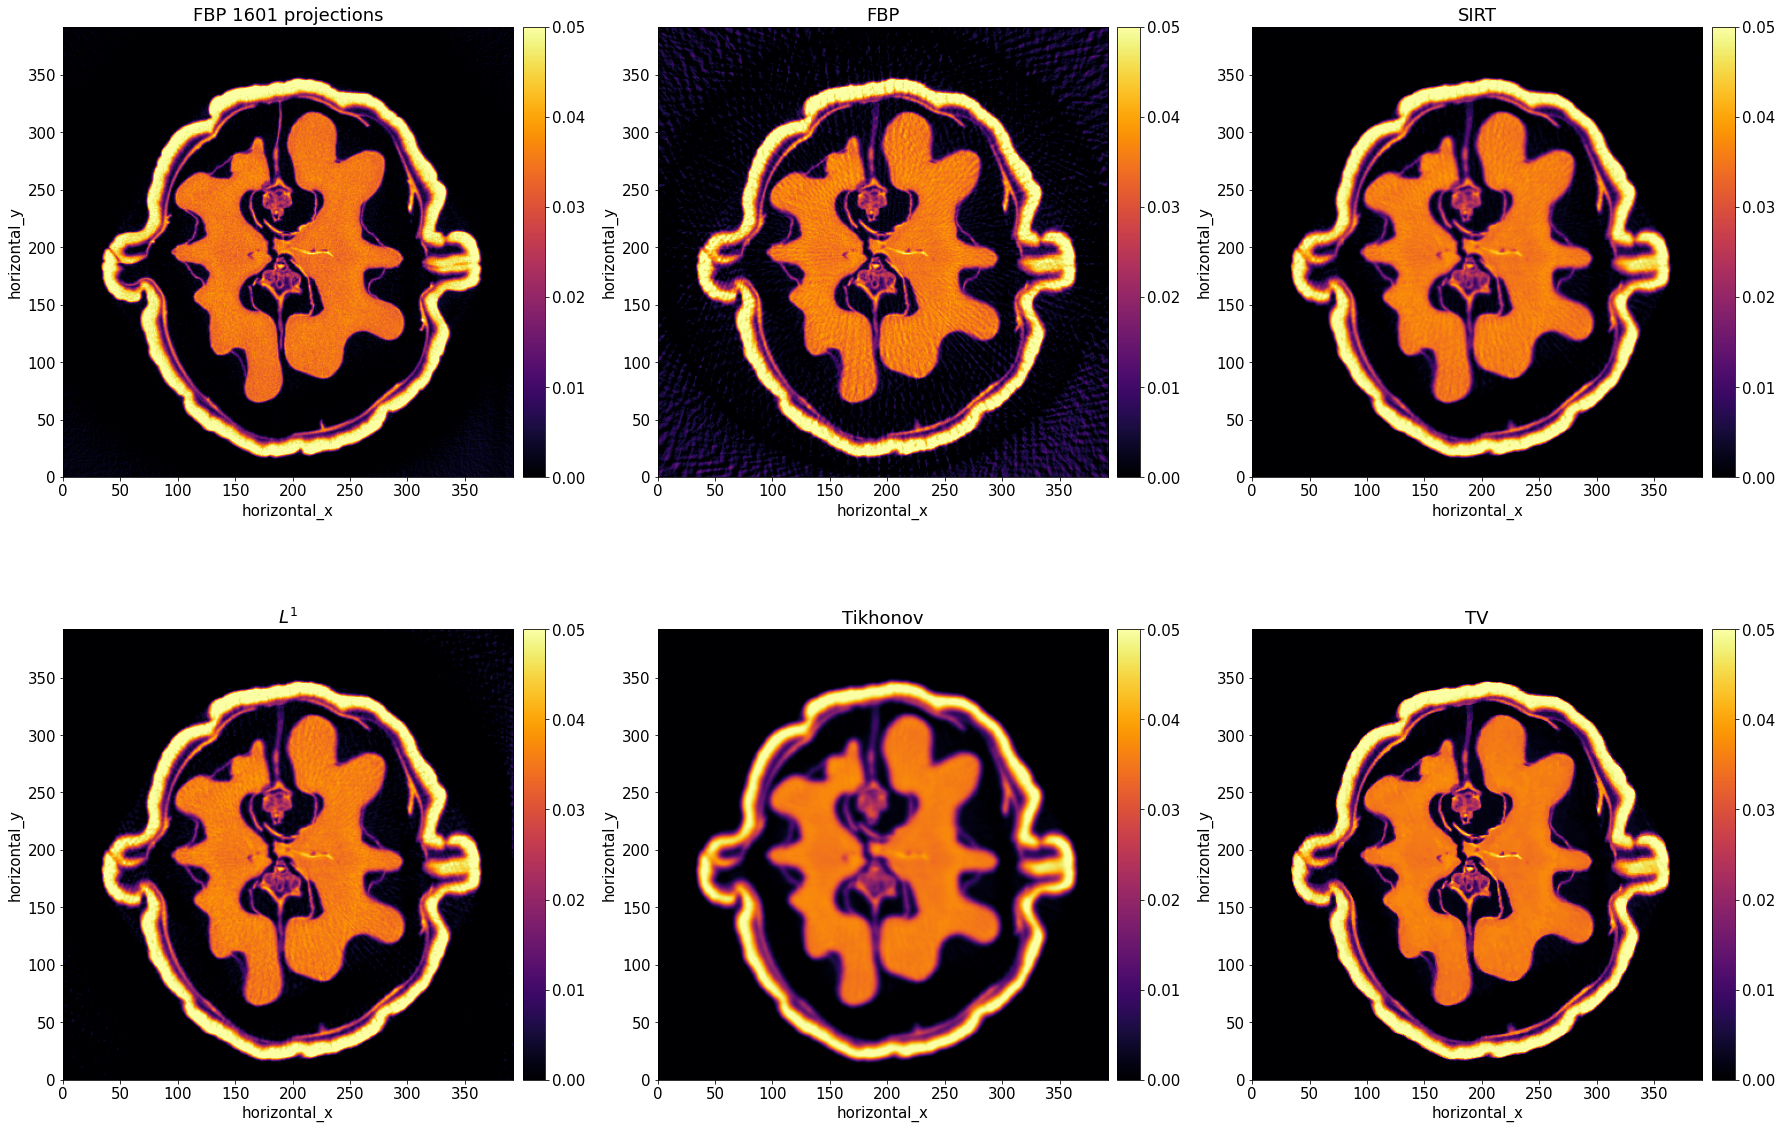

In [112]:
show2D([fbp_recon3D, 
        fbp_recon, 
        sirt_recon, 
        pdhg_l1.solution, 
        pdhg_tikhonov_explicit.solution,
        pdhg_tv_explicit.solution],
       title=['FBP 1601 projections', 'FBP', 'SIRT','$L^{1}$','Tikhonov','TV'],
                cmap="inferno",num_cols=3, size=(25,20), fix_range=(0,0.05))